### Discrete Fourier Transform (DFT)

In this notebook, we will do some simple audio recordings and observe their frequency spectrum using the discrete Fourier transform.

(**In progress... a more complete version of this to be done).

In [2]:
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
import IPython
from IPython.display import Audio, Image
%matplotlib notebook

### Fast Fourier Transform (FFT)

The Fast Fourier Transform (FFT), as the name implies, is a fast algorithm that is notorious for implementing a Discrete Fourier Transform (DFT). In Python and many other programming languages, there are pre-defined packages which compute the FFT. In Python, the FFT is done in the numpy package. 

Let's record a signal and have a look at its frequency spectrum, i.e. we will apply the FFT algorithm to implement the DFT of our recorded signal. We will use a sampling frequency, $f_{s} =  8 $ kHz and denote the total number of samples in the signal as $N$.


In [9]:
# Go ahead and sing, maybe something like a constant vocal, 'ahhhh..'
duration = 3  # seconds
fs = 16000    # Sampling frequency (Hz)
print ('recording...')
yy = sd.rec(duration * fs, blocking=True,samplerate=fs, channels=1)
print ('finished recording')


recording...
finished recording


Number of samples, N = 48000


<IPython.core.display.Javascript object>


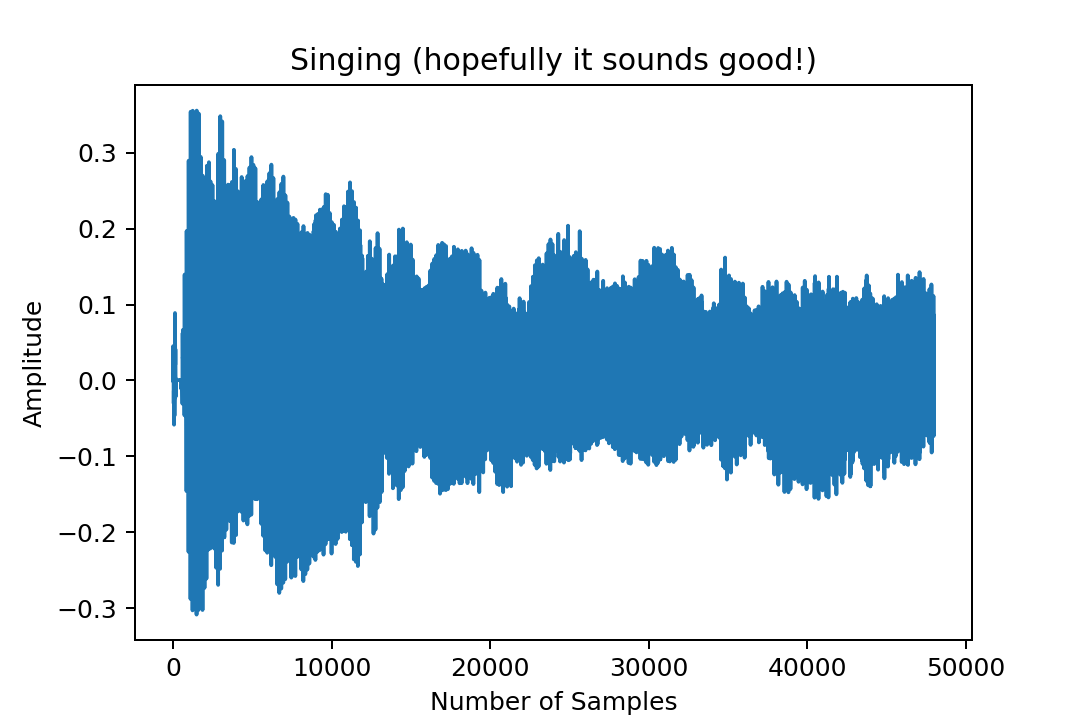

Text(0, 0.5, 'Amplitude')

In [10]:
IPython.display.display(Audio(yy.T, rate=fs))

print('Number of samples, N = '+str(len(yy)))
      
fig, axes = plt.subplots(figsize=(6, 4)) 

axes.plot(yy)
axes.set_title('Singing (hopefully it sounds good!)')
axes.set_xlabel('Number of Samples')
axes.set_ylabel('Amplitude')


Okay, so we have recorded a signal of 3 seconds at a sampling frequency of 8 kHz. 

The next step is to take the FFT of this signal. Recall that this FFT is going to give us both real and imaginary values, which means that we can plot both the magnitude and phase of the signal. The FFT function returns a vector of complex values, however, we need to know what frequency each of these values correspond to. In other words, we need to set up the corresponding frequency vector. This can be done using the python function np.fft.fftfreq, but we will make it ourselves so that we have a better understanding. The frequency bin spacing, $df$ between the samples is given by:

\begin{equation}
df = \frac{f_{s}}{N}
\end{equation}

This equation tells us that we can essentially increase our frequency resolution by including more points or by reducing the sampling frequency. This does not come without consequences however. When increasing the number of points, it means that we lose some temporal resolution of the signal (as we will see a bit later). If we alternatively reduce the sampling frequency, although we increase the resolution, we will reduce the maximum frequency up to which we have information (recall the Nyquist-Shannon sampling theorem from the whistling demo!).

Using this frequency bin spacing we can then make a vector starting from DC (0 Hz) to $f_{s}-df$. This will however include the double sided spectrum. In many practical cases, we may however only be interested in the single-sided spectrum, which goes up to $f_{s}/2$. 

More info. on the numpy fft routines are given here:
https://numpy.org/doc/stable/reference/routines.fft.html

Observe the frequency spectrum, if you made a sound such as 'ahhh', you should observe several peaks which may be harmonically related. 


<IPython.core.display.Javascript object>


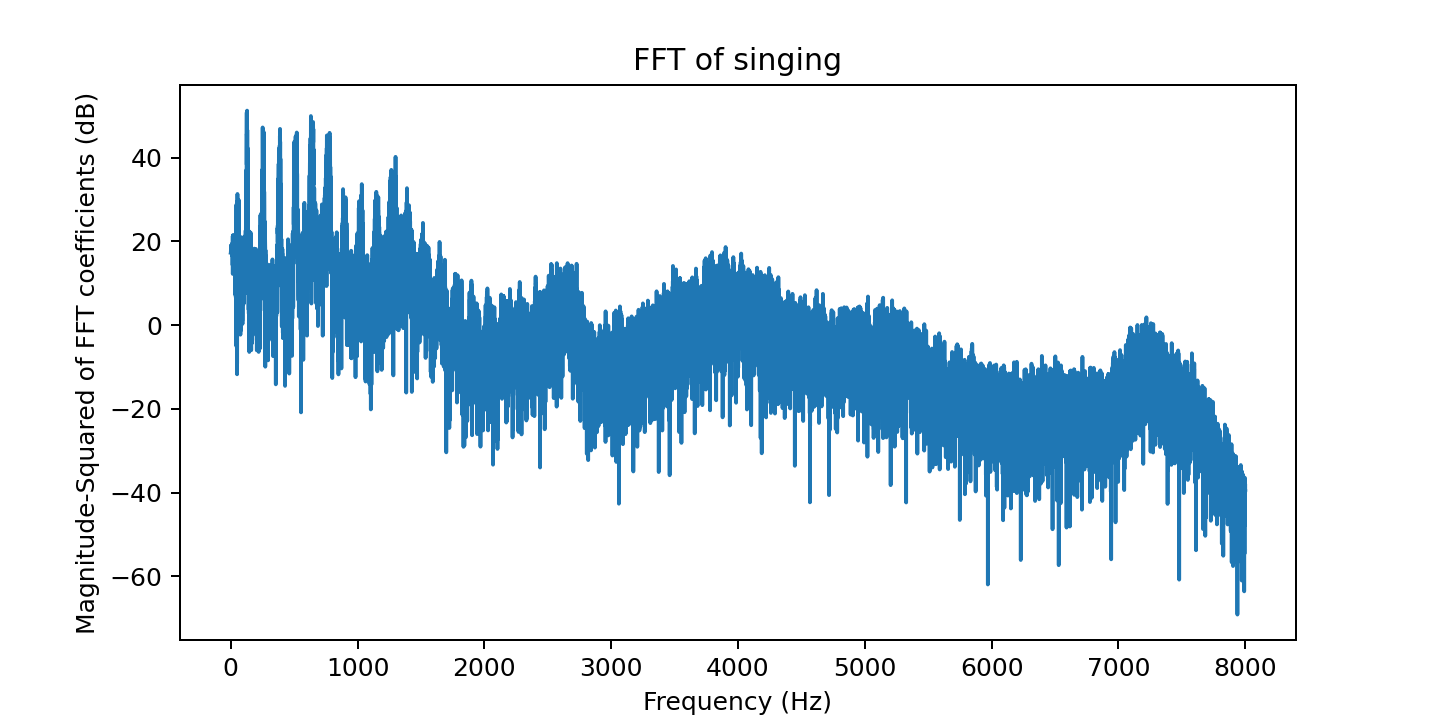

48000
Take a look at how the values are repeated after N/2
[-0.01263305-0.00119884j]
[-0.01017429+0.00074211j]
[-0.01042293+3.05311332e-16j]
[-0.01017429-0.00074211j]
[-0.01263305+0.00119884j]


In [12]:
# Apply the FFT to the signal

N = len(yy)
YY = np.fft.fft(yy,axis=0)  # make sure to specify the axis. zero in this case since the data is along the first axis.
                            # Since yy was an Nx1 vector, python wants to know just where the "N" values are, i.e. in axis = 0
YYss = YY[0:N//2+1]  # Single sided spectrum. The last value will be N/2, since python goes up to N-1 when slicing vectors like this.

#Set up the frequency vector
df = fs/N  # the frequency bin spacing
freqs = np.arange(0,fs/2+df,df) # first value = DC, last value = fs/2

# Let us plot the Magnitude-Squared 

fig, axes = plt.subplots(figsize=(8, 4)) 
axes.plot(freqs,10*np.log10(np.abs(YYss**2)))
axes.set_title('FFT of singing')
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Magnitude-Squared of FFT coefficients (dB)')

print(N)

print ("Take a look at how the values are repeated after N/2")
print(YY[N//2 - 2])
print(YY[N//2 - 1])
print(YY[N//2])
print(YY[N//2 + 1])
print(YY[N//2 + 2])


### Spectrograms - Time/Frequency Resolution

Sometimes there is need to not only view the frequency content of a signal, but also how this frequency content changes over time. This can be done using the short time Fourier transform (STFT), whereby the signal is segmented into smaller time frames, and an FFT is performed on each of these time frames. The result can be plotted in what we usually call a **Spectrogram**, where the magnitude-squared of the FFT coefficients is displayed as a colourmap over time and frequency. 

Let's view the spectrogram of our previous signal. One of the parameters we need to choose before hand is the length of these smaller time frames for the signal, i.e. the number of fft points to be used for each of these time frames. Recalling our previous formula for the frequency bin spacing, $df = f_{s}/N$, where $N$ is now defined as the length of the time frame. We can already see a problem of the time-frequency resolution trade-off because as $N$ is increased, the frequency resolution is increased, however, the time resolution decreases. Below, change the value of the nfft variable to observe the effect on the spectrogram. What do you think would be an appropriate value?



<IPython.core.display.Javascript object>


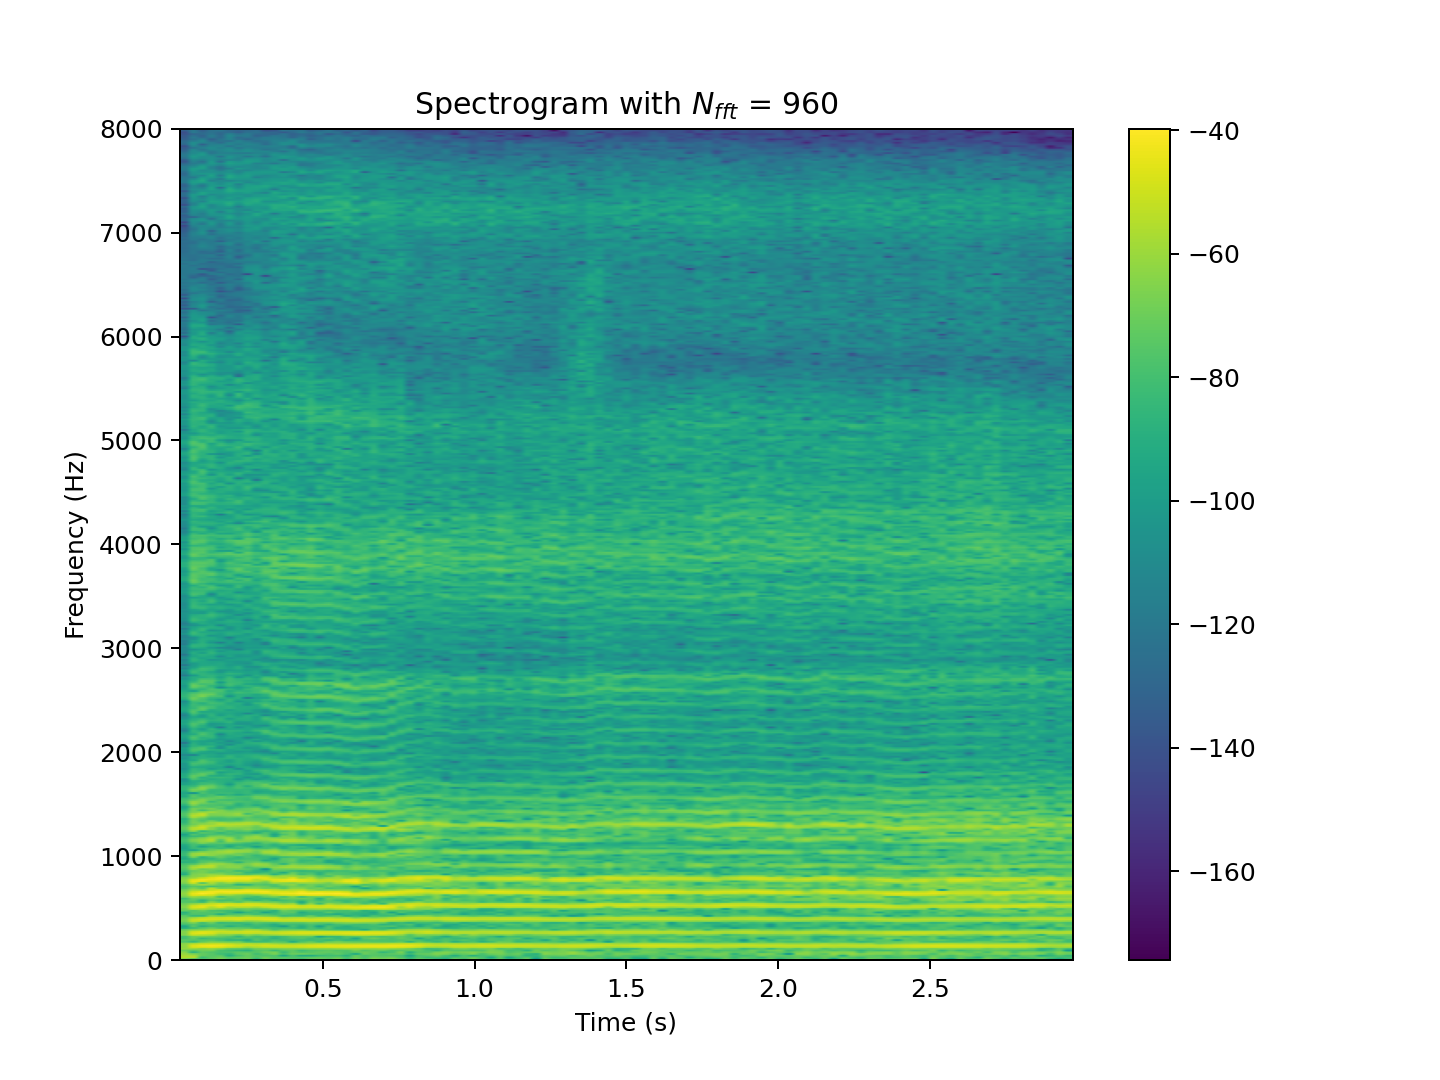

In [13]:
fig, axes = plt.subplots(figsize=(8, 6)) 

# Computing the spectrogram. We use the package signal which has a spectrogram function
nfft = N//50        # number of points for the FFT - change this value to see how the spectrogram changes 
noverlap = nfft/2   # Spectrogram overlap (make it 50 %)

# Compute the spectrogram. We set the mode to obtain the magnitude, 
# i.e absolute magnitude of the short-time Fourier transform (STFT) coefficients.
# Note that we are not concerned with the exact magnitude, i.e. sound pressure level of the signal
# A window is usually applied to the smaller time chunks to reduce any high frequency artifcats. 
# The segments are also usually overlapped to smooth out the temporal variations

f_sg, t_sg, Z_mag = signal.spectrogram(yy[:,0], fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB


# This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"

sp = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')
axes.set_title('Spectrogram with $N_{fft}$ = '+ str(nfft))
cb = plt.colorbar(sp,ax=[axes],location='right')
